In [1]:
import math
import numpy as np
from numpy import random
from matplotlib import pyplot as plt

# Quadratic functions

Let $m,n$ be two integers.

Given a matrix $A$, of size $m\times n$ and a vector $b\in\mathbb{R}^m$, we consider
\begin{equation*}
f_{A,b} : x\in\mathbb{R}^n \to \frac{1}{2} \left|\left| Ax-b \right|\right|_2^2.
\end{equation*}

**Question 1:** Provide implementations for $f_{A,b}$ and its gradient.

In [2]:
def f(A,b,x): return 0.5 * np.linalg.norm(A@x-b)**2

In [3]:
def grad_f(A,b,x): return A.T @ (A @ x - b)

**Question 2:** Using a finite difference approximation, check that your implementation of the gradient is correct.

In [4]:
ep = 1e-5
A = np.random.randn(10,5)
b = np.random.randn(10,1)
x = np.random.randn(5,1)
direction = np.random.randn(5,1)
print("Gradient in random direction:",(direction.T @ grad_f(A,b,x))[0,0])
print("Finite differences:", (f(A,b,x+ep*direction)-f(A,b,x)) / ep)

Gradient in random direction: -49.50373001116482
Finite differences: -49.503260650141094


**Question 3:** Implement a function gradient_descent$(A,b,T,\mbox{step})$ which runs gradient descent on $f_{A,b}$, starting at point $x_0=0$, for $T$ steps, with constant stepsize step.

In [5]:
def gradient_descent(A,b,T,step):
    
    print('Running gradient descent')
    
    n = np.shape(A)[1]
    
    # Initialize lists of iterates and objective values
    iterates = np.zeros((n,T+1))
    vals = np.zeros(T+1)
    vals[0] = f(A,b,np.zeros((n,1)))
    
    x = np.zeros((n,1))
    for t in range(1,T+1):
        # Descent step
        x = x - step * grad_f(A,b,x)
        # Record iterate and value
        iterates[:,t] = x.reshape(n)
        vals[t] = f(A,b,x)
        
    print('Final value: ',vals[T])
    
    return (iterates,vals)

**Question 4:** Implement a function $\verb+test+(m,n,T)$ which
* generates a random $m\times n$ matrix $A$ and an $m\times 1$ vector $b$,
* computes $L,\mu$, the Lipschitz and strong convexity constants of $f_{A,b}$,

[Hint : the largest and smallest singular values of a matrix $M$ are respectively given by np.linalg.norm$(M,2)$ and np.linalg.norm$(M,-2)$.]
* computes analytically the minimum of $f_{A,b}$ and a minimizer $x_{opt}$,
* runs $T$ steps of gradient on $f_{A,b}$, with stepsize $1/L$ and records the sequence of objective values, obj,
* plots obj $- \min f_{A,b}$ (using log-scale for the $y$-axis),
* plots (on the same figure) the upper bound on the convergence rate for $L$-smooth functions,
\begin{equation*}
t \to \frac{2L ||x_0-x_{opt}||_2^2}{t+4},
\end{equation*}
* plots the upper bound on the convergence rate for $L$-smooth and $\mu$-strongly convex functions,
\begin{equation*}
t \to \frac{L ||x_0-x_{opt}||_2^2}{2}\left(1-\frac{\mu}{L}\right)^{2t}.
\end{equation*}

In [6]:
def test(m,n,T):
    A = np.random.randn(m,n)
    b = np.random.randn(m,1)

    L= np.linalg.norm(A,2)**2
    mu= np.linalg.norm(A,-2)**2

    xopt = np.linalg.pinv(A) @ b
    val_opt = f(A,b,xopt)

    (iterates,vals) = gradient_descent(A,b,T,1/L)
    plt.yscale("log")
    plt.plot(vals-val_opt)
    plt.plot( L*np.linalg.norm(xopt)**2 / 2 * (1- mu/L)**(2*np.arange(T)))
    plt.plot(2*L*np.linalg.norm(xopt)**2 / (np.arange(T) + 4))

**Question 5:** Run several times test$(40,20,100)$ and test$(20,20,1000)$. Check that the upper bounds are above obj$-\min f_{A,b}$. [Note: if they don't, it means that there is an error in your code. Correct it!]

Comment the results.

Running gradient descent
Final value:  8.811949959178543


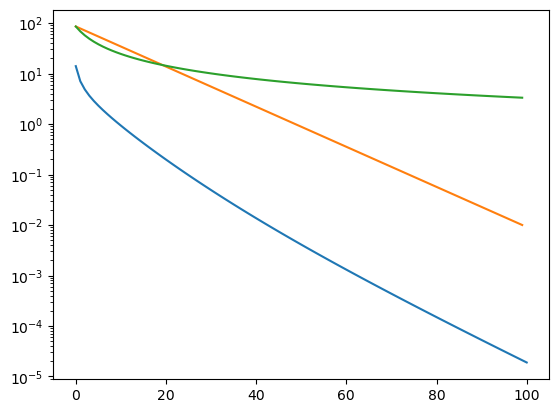

In [7]:
test(40,20,100)

Running gradient descent
Final value:  0.006005956554381838


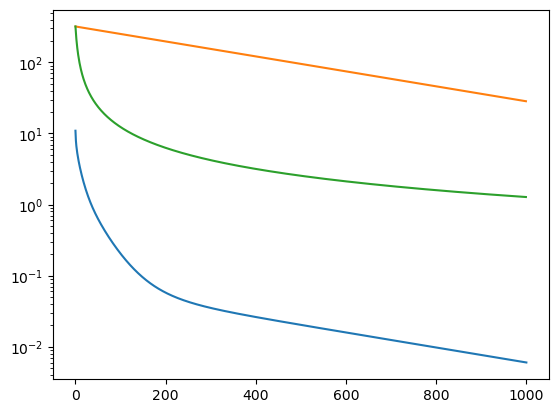

In [8]:
test(20,20,1000)

The upper bound for strongly convex smooth functions adequately describes the convergence rate of gradient descent (although the multiplicative constant is too large) when $m=40,n=20$, because, in this case, the strong convexity constant is not too large. When $m=20,n=20$, the strong convexity constant is very close to zero, and the upper bound for convex smooth functions provides a more accurate estimate, especially during the first hundreds of iterations.

**Question 6:** For $m=10,n=5$, run gradient descent on random $A$ and $b$ using stepsizes $\frac{0.1}{L},\frac{1}{L},\frac{10}{L}$. What is the difference?

Running gradient descent
Final value:  2.0260889880493416
Running gradient descent
Final value:  2.0239519909890973


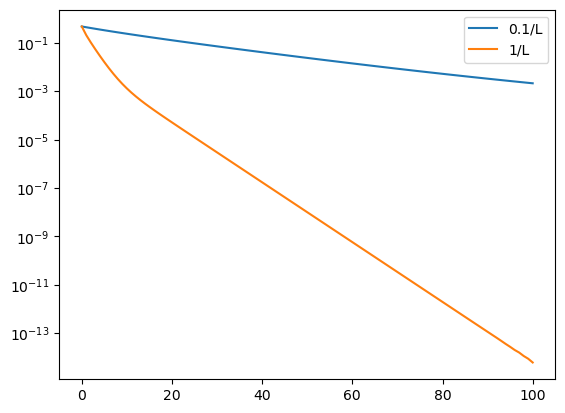

In [9]:
m = 10
n = 5
A = np.random.randn(m,n)
b = np.random.randn(m,1)

L= np.linalg.norm(A,2)**2

xopt = np.linalg.pinv(A) @ b
val_opt = f(A,b,xopt)

T = 100
(iterates1,vals1) = gradient_descent(A,b,T,0.1/L)
(iterates2,vals2) = gradient_descent(A,b,T,1/L)
iterates3,vals3) = gradient_descent(A,b,T,10/L)
plt.yscale("log")
plt.plot(vals1-val_opt,label="0.1/L")
plt.plot(vals2-val_opt,label="1/L")
plt.plot(vals3-val_opt,label="10/L")
plt.legend()

When the stepsize is $10/L$, gradient descent diverges. When it is $0.1/L$, gradient descent converges, but much more slowly than with stepsize $1/L$.

**Question 7:** Implement a variant of your function gradient_descent, where the stepsize is determined by backtracking linesearch. Use, for instance, a coefficient $0.3$ in the Armijo-Goldstein condition, and scale the step by $0.6$ at each iteration.

In [10]:
def gradient_descent_backtrack(A,b,T):
    
    print('Running gradient descent')
    
    n = np.shape(A)[1]
    
    # Initialize lists of iterates and objective values
    iterates = np.zeros((n,T+1))
    vals = np.zeros(T+1)
    vals[0] = f(A,b,np.zeros((n,1)))
    
    x = np.zeros((n,1))
    for t in range(1,T+1):
        direction = grad_f(A,b,x)
        # Backtracking linesearch
        step = 1
        x_tmp = x - step * direction
        while (f(A,b,x_tmp) > f(A,b,x) -(1/3)*step*np.linalg.norm(direction)**2):
            step = step * 0.6
            x_tmp = x - step * direction
        x = x_tmp
        # Record
        iterates[:,t] = x.reshape(n)
        vals[t] = f(A,b,x)
        
    print('Final value: ',vals[T])
    
    return (iterates,vals)

**Question 8:** For $m=10,n=5$, compare the function with backtracking to gradient descent with constant stepsize.

Running gradient descent
Final value:  1.2315778503901624
Running gradient descent
Final value:  1.1803255843757778
Running gradient descent
Final value:  1.1803255842601716


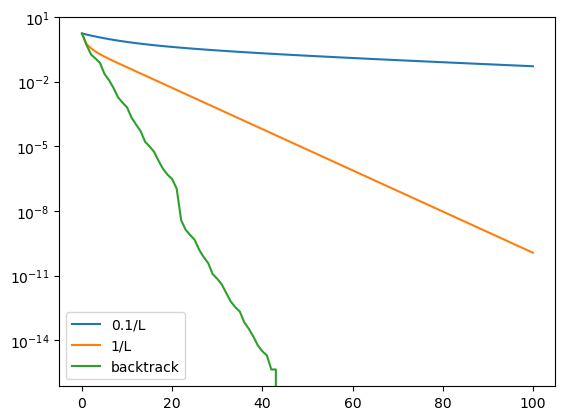

In [11]:
m = 10
n = 5
A = np.random.randn(m,n)
b = np.random.randn(m,1)

L= np.linalg.norm(A,2)**2

xopt = np.linalg.pinv(A) @ b
val_opt = f(A,b,xopt)

T = 100
(iterates1,vals1) = gradient_descent(A,b,T,0.1/L)
(iterates2,vals2) = gradient_descent(A,b,T,1/L)
(iterates3,vals3) = gradient_descent_backtrack(A,b,T)
plt.yscale("log")
plt.plot(vals1-val_opt,label="0.1/L")
plt.plot(vals2-val_opt,label="1/L")
plt.plot(vals3-val_opt,label="backtrack")
plt.legend()